## CHARACTERISTIC RADIUS R+

In [1]:
import sys,os
sys.path.append('../')

# General
import glob
import os.path
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.colors import Normalize
# from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import pandas as pd

# Data treatment
import dask as da
from dask.diagnostics import ProgressBar
import zarr
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from datetime import datetime

# Custom
import functions as f
# import plotUtils as pu

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PRMS = {
    'n':                5, # R+ is defined as omega(R+) = n * f
    'save_figs':        False,
}

PTHS = {
    'data_dir':         '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
    'dsg_pth':          '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
    'dsg2_pth':         '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_17102022_with_extra_params.nc',
    'save_dir':         '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_STEADY_STATE_CRIT/03_CHARAC_RADIUS/',
}

### OPEN DATA
all_data = glob.glob(PTHS['data_dir'] + "*.nc")
print("Total number of files:", len(all_data))

Total number of files: 335


In [3]:
dsg = xr.open_dataset(PTHS['dsg_pth'])

### Add intensification parameters
dsg2 = xr.open_dataset(PTHS['dsg2_pth'])
dsg['Vmax_dot_smth_IBT'] = xr.DataArray(
    data=np.array(dsg2['Vmax_dot_smth_IBT']),
    coords={'time': dsg.time}
)
dsg['Vmax_dot_IBT'] = xr.DataArray(
    data=np.array(dsg2['Vmax_dot_IBT']),
    coords={'time': dsg.time}
)
dsg['R17_dot_IBT'] = xr.DataArray(
    data=np.array(dsg2['R17_dot_IBT']),
    coords={'time': dsg.time}
)
dsg['R17_dot_smth_IBT'] = xr.DataArray(
    data=np.array(dsg2['R17_dot_smth_IBT']),
    coords={'time': dsg.time}
)

### Kinetic energy
K1_SAR = dsg['Vmax_1D'] * (dsg['Vmax_dot_smth_IBT'] * 3600) * ((dsg['R17_1D'] * 1000) ** 2)
K2_SAR = dsg['R17_1D'] * 1000 * (dsg['R17_dot_smth_IBT'] * 1000 * 3600) * (dsg['Vmax_1D'] ** 2)
K1_IBT = dsg['Vmax_IBT'] * (dsg['Vmax_dot_smth_IBT'] * 3600) * ((dsg['R34_IBT']) ** 2) 
K2_IBT = dsg['R34_IBT'] * (dsg['R17_dot_smth_IBT'] * 1000 * 3600) * (dsg['Vmax_IBT'] ** 2)

dsg['dKdt_SAR'] = K1_SAR + K2_SAR
dsg['dKdt_IBT'] = K1_IBT + K2_IBT

In [4]:
### FILTER
dsg = dsg.where(dsg.distance_to_coast > dsg.R17_1D * 1000, drop=True)
dsg = dsg.where(abs(dsg.lat_center) < 30, drop=True)
dsg = dsg.where(dsg.B_hol > 0.1, drop=True)
dsg = dsg.where(dsg.Vmax_1D > 20, drop=True)
# dsg = dsg.where(dsg.lon_center < -50, drop=True) # Keep only USA best-track agencies
# dsg = dsg.where(dsg.distance_to_coast > 200000, drop=True)
print('Nb of storms: {}'.format(len(dsg.time)))

print('SAR Mean Rmax = {:.0f} km'.format(dsg.Rmax_1D.mean()))
print('SAR Mean R64  = {:.0f} km'.format(dsg.R33_1D.mean()))

Nb of storms: 184
SAR Mean Rmax = 32 km
SAR Mean R64  = 57 km


In [5]:
# dsg[['sat_file', 'storm_id']].astype(str).to_netcdf('/home/arthur/Téléchargements/dsg.nc')

### Characteristic radius R+

In [6]:
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def holland_profile(r, lat, pn, pc, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor  = abs(coriolis(lat))
    rho   = 1.15
    # B     = (Vmax ** 2) * rho * np.e / (pn - pc)
    B     = ((Vmax - Vmin) ** 2) * rho * np.e / (pn - pc)
    A     = Rmax ** B
    
    r     = r.astype(np.float) + 0.001 # To avoid dividing by zero
    V     = r * 0.
    V     = Vmin + np.sqrt(A * B * (pn - pc) * np.exp((-1) * A / (r ** B)) / (rho * r ** B) + (r ** 2 * fcor ** 2) / 4) - (r * fcor / 2)
    return V

rs = np.linspace(0, 500000, 50001) # define dr accordingly
def vorticity(r, v):
    '''Relative vorticity'''
    dr = 10 # meters
    return (1 / r) * np.gradient(r * v, dr)

In [7]:
rs  = np.linspace(0, 500000, 50001)
n   = PRMS['n']
DSs = dsg.mean(dim='theta', skipna=True)

# Initialize
DSs['R_plus'] = DSs['Vmax_1D'].copy(deep=True) * np.nan
DSs['V_plus'] = DSs['Vmax_1D'].copy(deep=True) * np.nan

for t in tqdm(np.arange(len(DSs.time))):
    ds       = DSs.isel(time=t)
    Vh       = holland_profile(rs, float(abs(ds.lat_center)), float(ds.pn_hol), float(ds.pc_hol), float(ds.Vmin_hol), float(ds.Rmax_hol), float(ds.Vmax_hol))
    rm       = float(ds.Rmax_hol)
    out      = rs > rm                             # To find outer-core
    r        = rs[out]
    vrt      = vorticity(rs, Vh)[out]              # Relative vorticity
    vrt_plan = float(abs(coriolis(ds.lat_center))) # Planetary vorticity
    
    # # Plot vertical velocity
    # q  = r * (Vh[out] ** 2) / (vrt + vrt_plan)
    # Cd = 2e-5
    # dr = 10 # meters
    # we = (Cd / r) * np.gradient(q, dr)
    # plt.plot(we, c='gray', alpha=0.25)
    # plt.ylim(-0.001, 0.01)
    
    try: 
        R_plus =  r[abs(vrt - n * vrt_plan) < 1e-7][0] 
        V_plus = ds.sel(rad=slice(R_plus - 500, None)).wind_speed[0]
    except IndexError:
        R_plus = V_plus = np.nan
    
    DSs['R_plus'][t] = R_plus
    DSs['V_plus'][t] = V_plus

100%|████████████████████████████████████████| 184/184 [00:01<00:00, 109.18it/s]


In [8]:
### DATASET FOR PAUL

# ### Computing Kinetic Energy
# V34         = 17.5 # m/s
# g           = 9.8  # m/s^2
# rho         = 1.15 # kg/m^3
# theta_ratio = 1e-2 # []

# # Below, dK/dt is expressed in J/hr, where 1J = 1 kg m^2 s^-2
# DSs['dKdt'] = (rho * V34 ** 2 / (g * theta_ratio)) * 2 * (DSs['R17_1D'] * 1000 * DSs['Vmax_1D']) * ((DSs['Vmax_dot_smth_IBT']) * (DSs['R17_1D'] * 1000) + (DSs['R17_dot_smth_IBT'] * 1000) * DSs['Vmax_1D'])
# nrm         = 1e15
# DSs['dKdt'] = DSs['dKdt'] / nrm # now in PJ/hr

# # Save data
# vars2drop               = ['interpolated_track_point', 'eye_center', 'lon_eye_c', 'lat_eye_c', 'lon_trk_c', 'lat_trk_c', 'storm_name', 'storm_id', 'sat_file', 'sat_pth']
# DSs_clean               = DSs.drop_vars(vars2drop)
# DSs_clean['storm_name'] = DSs['storm_name'].astype(str)
# DSs_clean['storm_id']   = DSs['storm_id'].astype(str)
# DSs_clean['sat_file']   = DSs['sat_file'].astype(str)
# DSs_clean['sat_pth']    = DSs['sat_pth'].astype(str)
# DSs_clean.to_netcdf(PTHS['save_dir'] + 'dsg_rpls.nc')

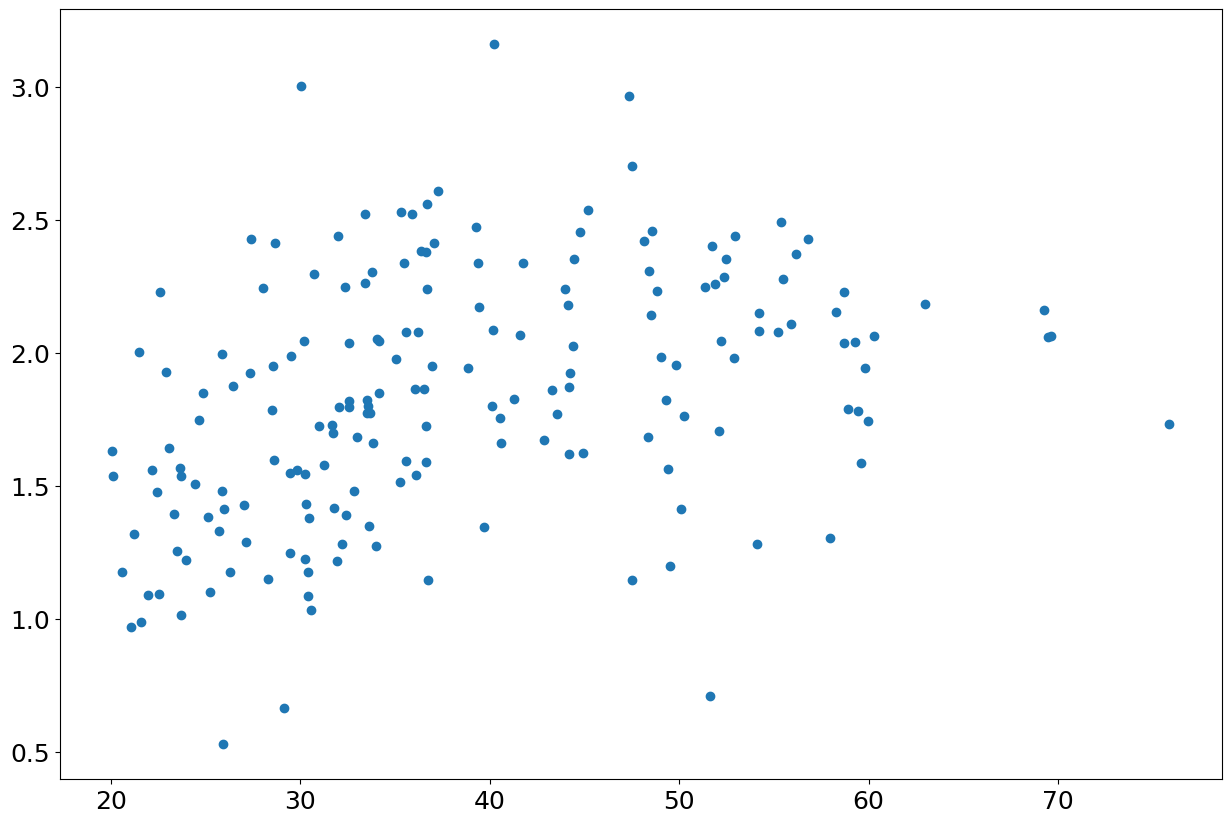

In [9]:
plt.scatter(DSs.Vmax_1D, DSs.B_hol)

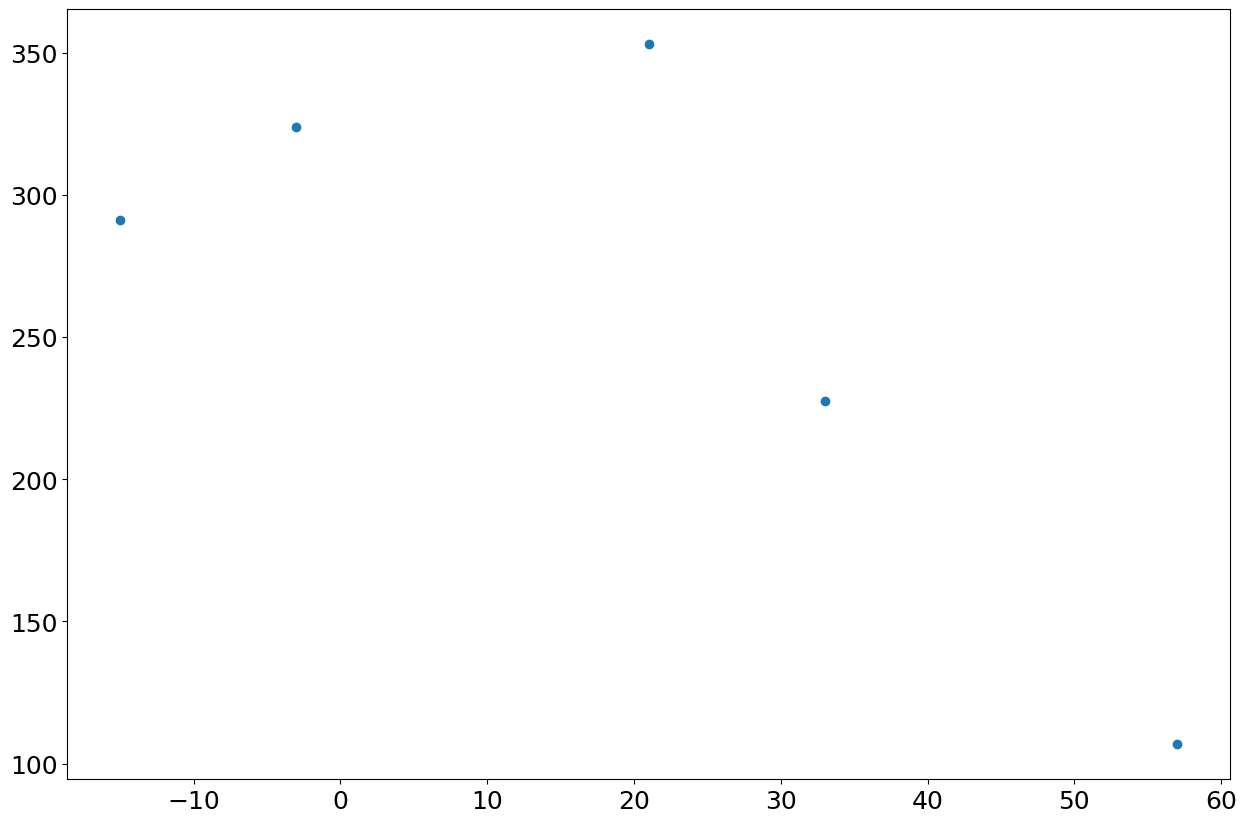

In [10]:
d = DSs.where(DSs.storm_name == 'MARIE', drop=True)
q = d.cyclone_speed * (d.Vmax_1D ** 2) / (d.V_plus)
plt.scatter(d.hrs_since_lmi, q)

In [11]:
# ITERATE
listOfDatasets = []
rf             = np.linspace(0.05, 5, 10000)

for t in tqdm(np.arange(len(DSs.time))):
    ds  = DSs.isel(time=t)
    rv2 = (ds.rad * (ds.wind_speed ** 2)) / (ds.R_plus * (ds.V_plus ** 2))
    
    if ~np.isnan(ds.R_plus):
        dsr = xr.Dataset(
            data_vars={
                'rv2':  ('r_star', np.array(rv2)),
                'B':    float(ds.B_hol),
                'x':    float(ds.x_rkn),
                'Vfm':  float(ds.cyclone_speed),
                'Vmax': float(ds.Vmax_1D),
                'Rmax': float(ds.Rmax_1D),
                'lat':  float(ds.lat_center)
            },
            coords={'r_star': np.array(ds.rad / (ds.R_plus))}
        )
        listOfDatasets.append(dsr.interp(coords={'r_star': rf}))

print('Concatenating...')
dss = xr.concat(listOfDatasets, dim='i')
print('Concatenation ended.')

100%|████████████████████████████████████████| 184/184 [00:01<00:00, 120.62it/s]


Concatenating...
Concatenation ended.


V+ = 31.5 m/s
V+ = 32.9 m/s
V+ = 34.8 m/s


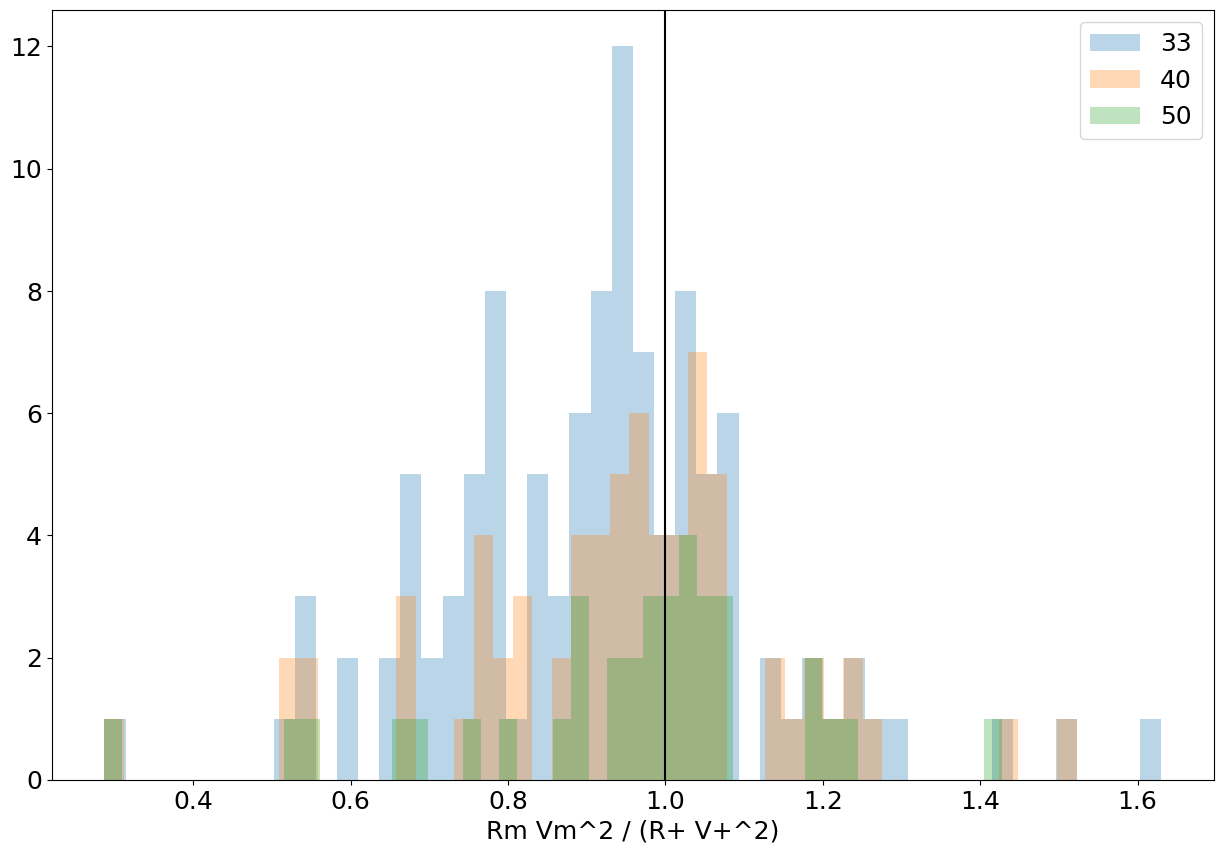

In [12]:
ws = [33, 40, 50]
for s in ws:
    d  = DSs.where(DSs.Vmax_1D > s, drop=True)
    print('V+ = {:.1f} m/s'.format(d.V_plus.mean(skipna=True)))
    plt.hist(d.Rmax_1D * 1000 * (d.Vmax_1D ** 2) / (d.R_plus * (d.V_plus ** 2)), bins=50, alpha=0.3, label=str(s))
plt.legend()
plt.xlabel('Rm Vm^2 / (R+ V+^2)')
plt.axvline(1, c='k')

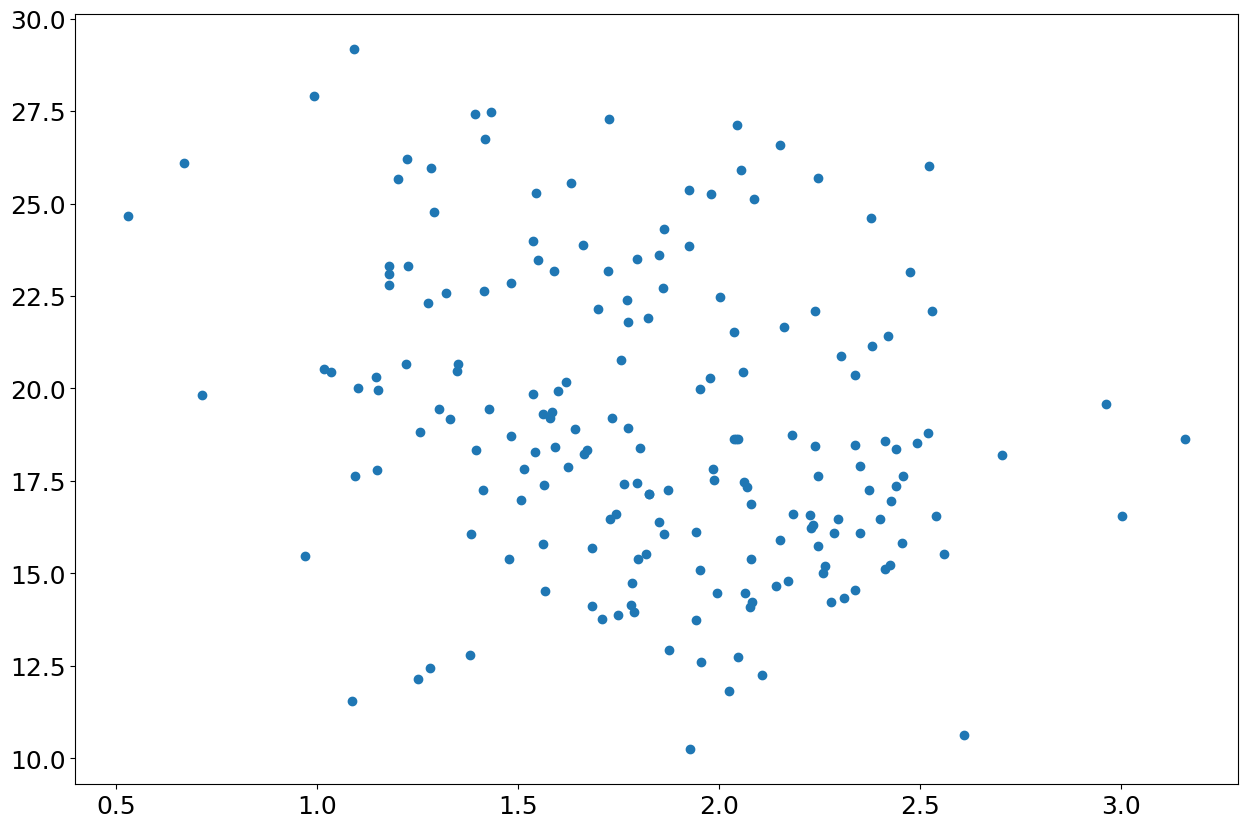

In [13]:
plt.scatter(DSs.B_hol, abs(DSs.lat_center))

V+ = 32.9 m/s


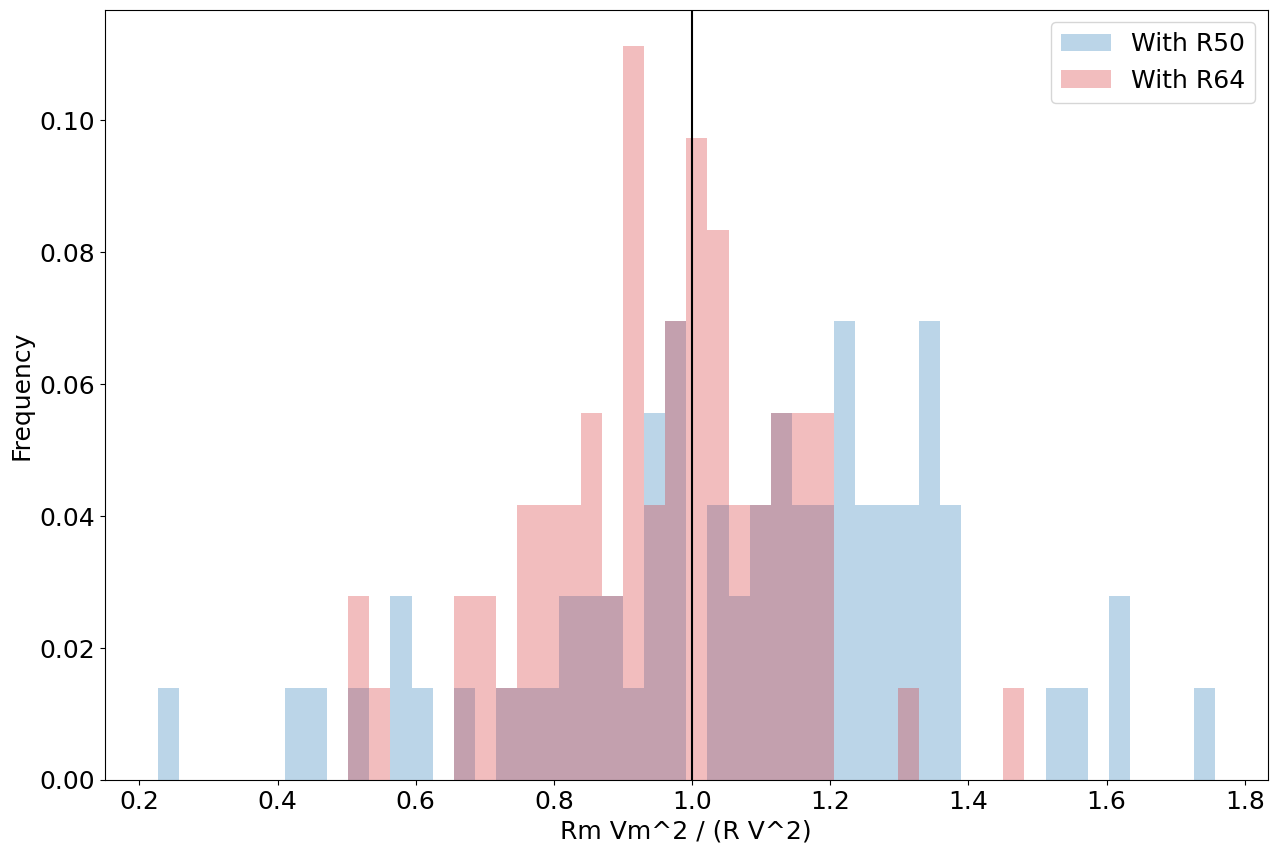

In [14]:
d    = DSs.where(DSs.Vmax_1D > 40, drop=True)
print('V+ = {:.1f} m/s'.format(d.V_plus.mean(skipna=True)))
bins = plt.hist(d.Rmax_1D * (d.Vmax_1D ** 2) / (d.R26_1D * (25.7222 ** 2)), weights=np.zeros_like(d['R26_1D']) + 1. / float(d['R26_1D'].notnull().sum()), bins=50,      alpha=0.3, label='With R50', color='tab:blue')
plt.hist(d.Rmax_1D * (d.Vmax_1D ** 2) / (d.R33_1D * (32.9244 ** 2)), weights=np.zeros_like(d['R33_1D']) + 1. / float(d['R33_1D'].notnull().sum()),        bins=bins[1], alpha=0.3, label='With R64', color='tab:red')
plt.legend()
plt.xlabel('Rm Vm^2 / (R V^2)')
plt.ylabel('Frequency')
plt.axvline(1, c='k')

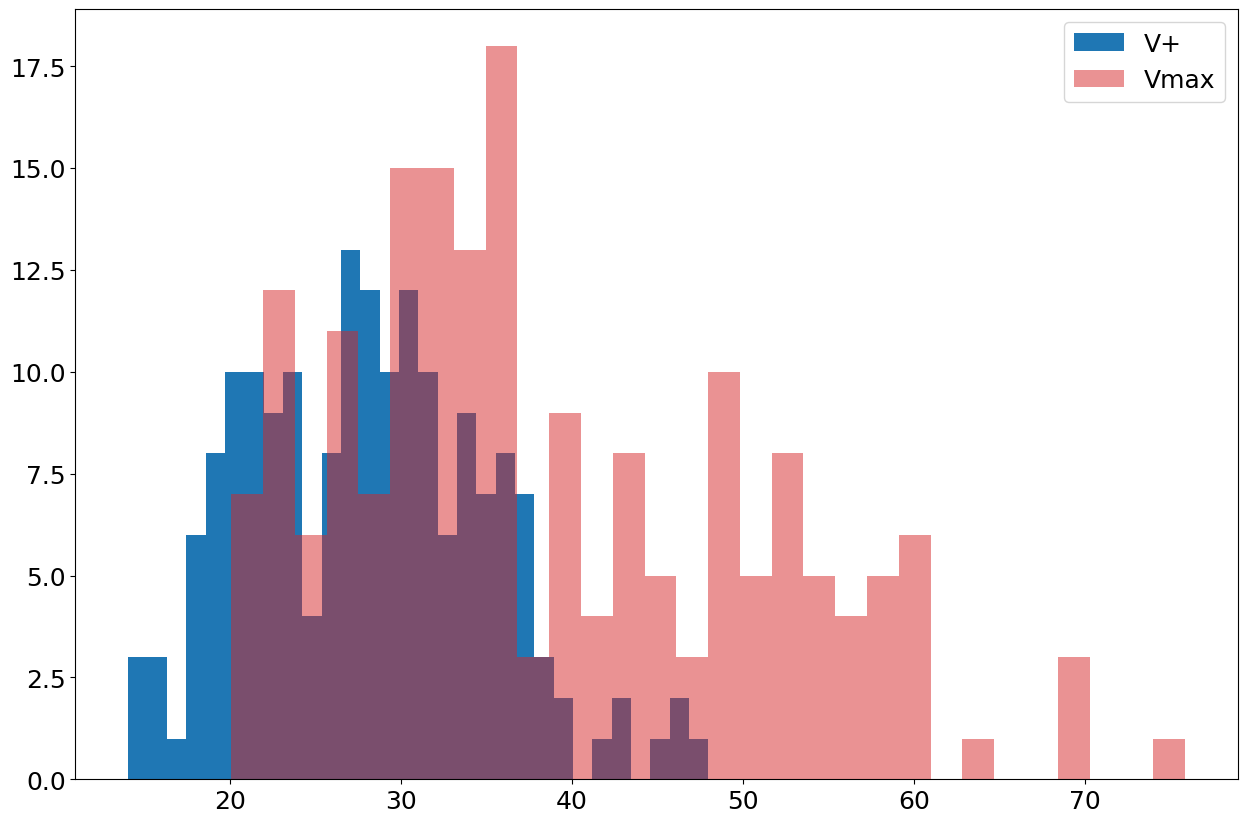

In [15]:
plt.hist(DSs.V_plus, bins=30, label='V+')
plt.hist(DSs.Vmax_1D, bins=30, color='tab:red', alpha=0.5, label='Vmax')
plt.legend()

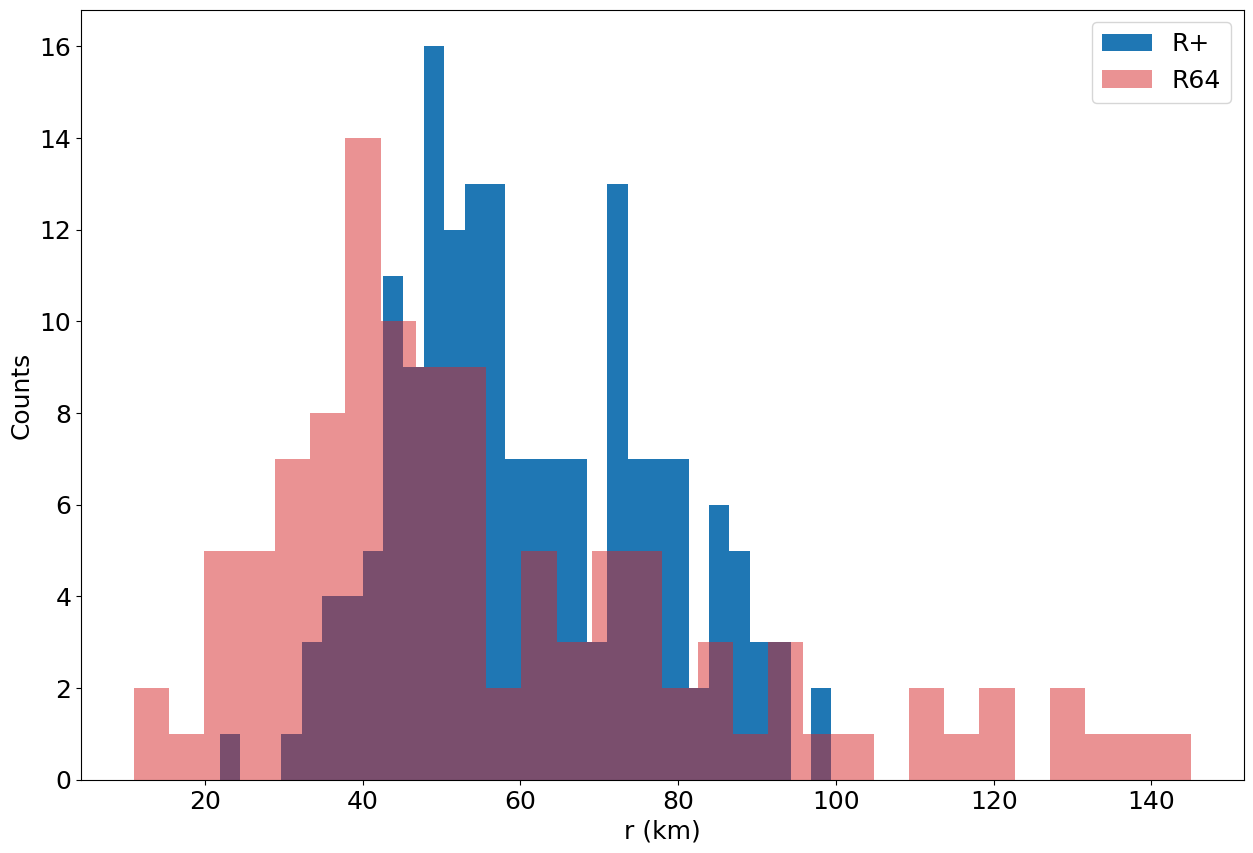

In [16]:
plt.hist(DSs.R_plus / 1000, bins=30, label='R+')
plt.hist(DSs.R33_1D, bins=30, color='tab:red', alpha=0.5, label='R64')
plt.ylabel('Counts');plt.xlabel('r (km)')
plt.legend()

100%|████████████████████████████████████████| 178/178 [00:00<00:00, 409.72it/s]


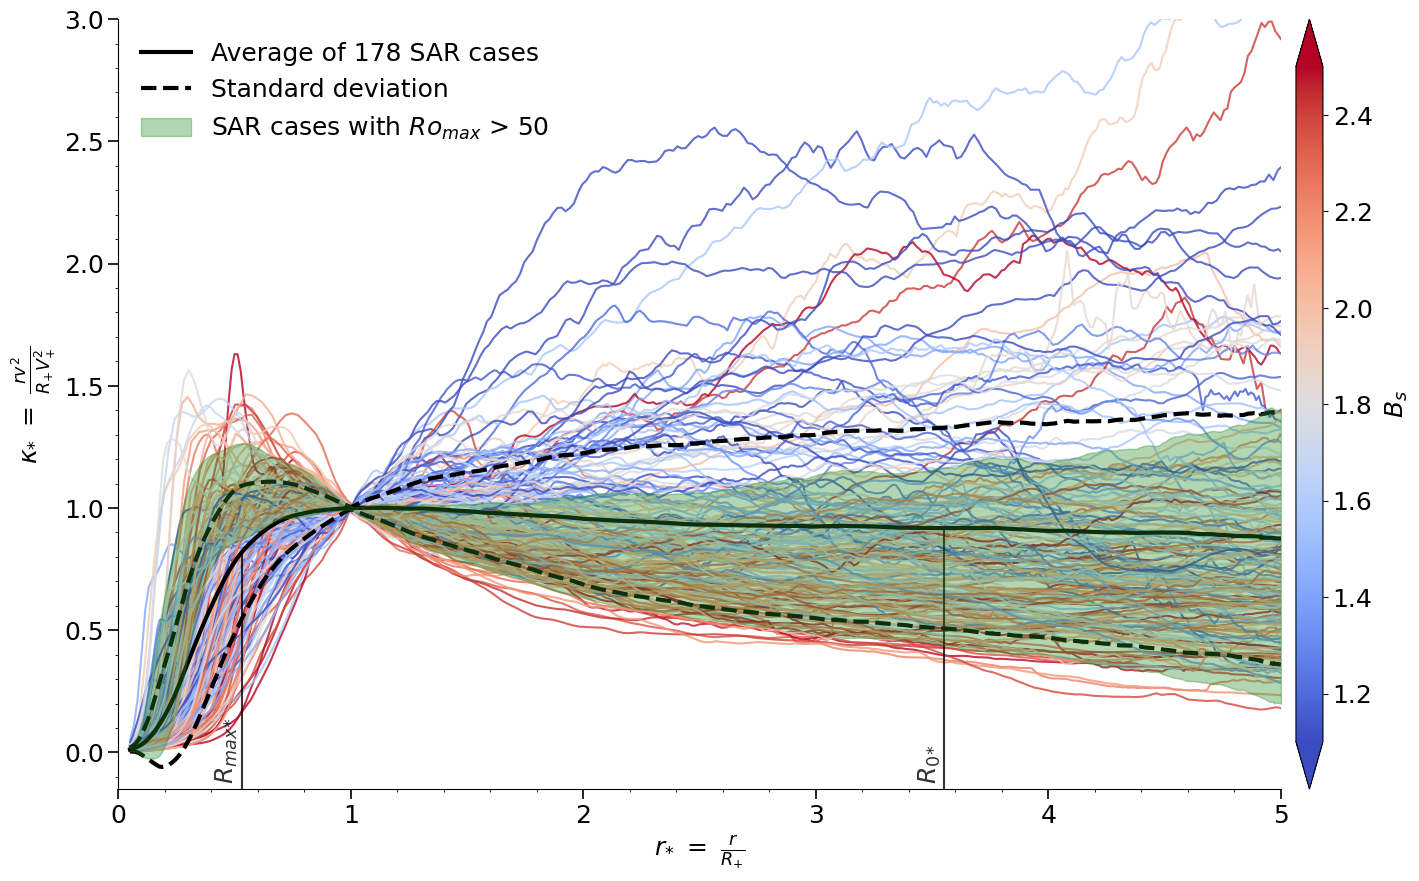

In [22]:
fig, ax     = plt.subplots(figsize=(15, 10))

c_min = 1.1
c_max = 2.5

dss['B_color'] = (dss.B - c_min) / (c_max - c_min)
cmap           = cm.get_cmap('coolwarm')

rv2m = dss.mean(dim='i').rv2
rv2s = dss.std(dim='i').rv2

# Iterate
for i in tqdm(np.arange(len(dss.i))):
    dss.isel(i=i).rv2.plot(color=cmap(dss.isel(i=i).B_color), alpha=0.8)

# Wind radii
# plt.axvline(1, c='k', linewidth=3, label='R+')
# ax.axvline((DSs.R17_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True), ymin=0, ymax=float(rv2m.sel(r_star=(DSs.R17_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True), method='nearest')) / 2.75, linewidth=1.5, c='k', alpha=0.8)
# ax.axvline((DSs.R33_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True), ymin=0, ymax=float(rv2m.sel(r_star=(DSs.R33_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True), method='nearest')) / 2.75, linewidth=1.5, c='k', alpha=0.8)
ax.axvline((DSs.Rmax_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True), ymin=0, ymax=float(rv2m.sel(r_star=(DSs.Rmax_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True), method='nearest')) / 2.7, linewidth=1.5, c='k', alpha=0.8)
trans = ax.get_xaxis_transform()
# ax.text((DSs.R17_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True) - 0.12,  .015, r'$R_{34}$$_{*}$',  c='k', alpha=0.8, transform=trans, rotation='vertical')
# ax.text((DSs.R33_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True) - 0.12,  .015, r'$R_{64}$$_{*}$',  c='k', alpha=0.8, transform=trans, rotation='vertical')
ax.text((DSs.Rmax_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True) - 0.12, .015, r'$R_{max}$$_{*}$', c='k', alpha=0.8, transform=trans, rotation='vertical')
# R0
R0 = np.sqrt(2 * DSs.Rmax_1D * 1000 * DSs.Vmax_1D / (abs(coriolis(DSs.lat_center)))).mean(skipna=True)
ax.axvline(R0 / DSs.R_plus.mean(skipna=True), ymin=0, ymax=0.34, linewidth=1.5, c='k', alpha=0.8)
ax.text(R0 / DSs.R_plus.mean(skipna=True) - 0.12, .015, r'$R_{0}$$_{*}$', c='k', alpha=0.8, transform=trans, rotation='vertical')

# Mean and std
rv2m.plot(c='k', linewidth=3, label='Average of {} SAR cases'.format(len(dss.i)))
ax.plot(dss.r_star, rv2m + rv2s, c='k', linestyle='dashed', linewidth=3, label='Standard deviation')
ax.plot(dss.r_star, rv2m - rv2s, c='k', linestyle='dashed', linewidth=3)
# Stronger than thrsh m/s
dss['Ro'] = dss.Vmax / (abs(coriolis(dss.lat)) * dss.Rmax * 1000)
thrsh     = 50
d_hgh     = dss.where(dss.Ro > thrsh, drop=True)
rv2m_hgh  = d_hgh.mean(dim='i').rv2
rv2s_hgh  = d_hgh.std(dim='i').rv2
ax.fill_between(dss.r_star, rv2m_hgh - rv2s_hgh, rv2m_hgh + rv2s_hgh, color='forestgreen', label=r'SAR cases with $Ro_{max}$ > ' + '{}'.format(str(thrsh)), zorder=2, alpha=0.35)

# Grid, legend
# ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
# ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylim(-0.15, 3)
ax.set_xlim(0, 5)
ax.set_ylabel(r'$\kappa_{*}$ $=$ $\frac{rv^2}{R_{+} V_{+}^2}$')
ax.set_xlabel(r'$r_{*}$ $=$ $\frac{r}{R_{+}}$')
ax.legend(loc='upper left', frameon=False)

# Colorbar
norm = mpl.colors.Normalize(vmin=c_min, vmax=c_max)
sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cb_ax = fig.add_axes([0.91, 0.11, 0.018, 0.77])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.set_label(r'$B_s$', rotation=90)
cbar.ax.get_yaxis().labelpad=8

# plt.savefig(PTHS['save_dir'] + 'rv2_charac.pdf', bbox_inches='tight', format='pdf')

if PRMS['save_figs']:
    plt.savefig(PTHS['save_dir'] + 'rv2_charac.pdf', bbox_inches='tight', format='pdf')

In [18]:
lane    = DSs.where(DSs.sat_file == 's1a-iw-owi-cm-20180823t043704-20180823t043913-000003-028AD1_sw.nc', drop=True).isel(time=0)
meranti = DSs.where(DSs.sat_file == 'rs2--owi-cm-20160912t212718-20160912t213122-00003-BDC5F_sw.nc', drop=True).isel(time=0)

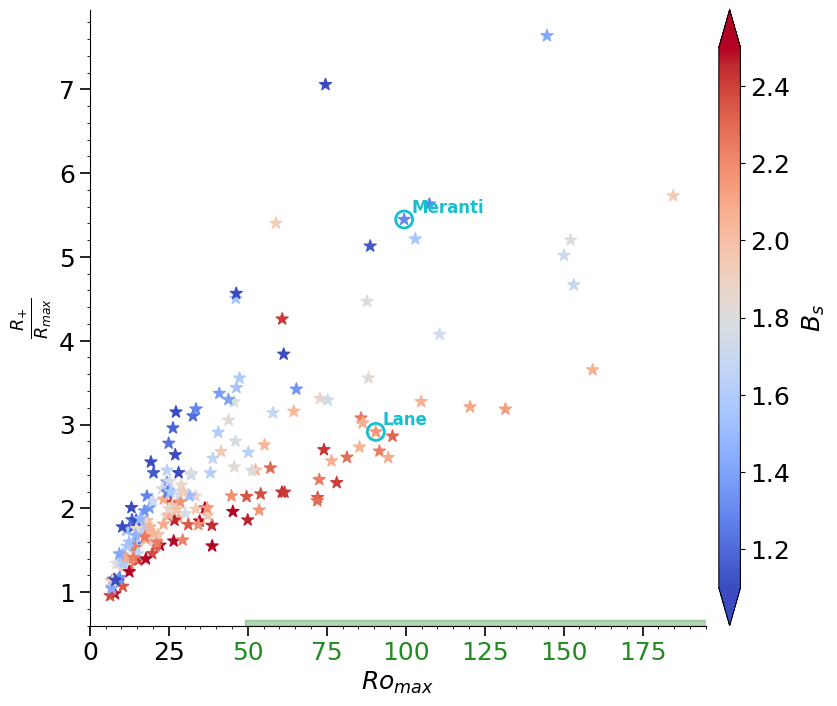

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))

rossby  = DSs.Vmax_1D / (abs(coriolis(DSs.lat_center)) * DSs.Rmax_1D * 1000)

# Scatter
sm = ax.scatter(rossby, DSs.R_plus / (DSs.Rmax_1D * 1000), c=DSs.B_hol, cmap=cm.get_cmap('coolwarm'), vmin=1.1, vmax=2.5, marker='*', s=80)

# Cases
clr = 'tab:cyan'
ax.scatter(lane.Vmax_1D / (abs(coriolis(lane.lat_center)) * lane.Rmax_1D * 1000), lane.R_plus / (lane.Rmax_1D * 1000), facecolors='None', edgecolors=clr, s=150, linewidth=2)
ax.annotate('Lane', (lane.Vmax_1D / (abs(coriolis(lane.lat_center)) * lane.Rmax_1D * 1000), lane.R_plus / (lane.Rmax_1D * 1000)), fontsize=12, color=clr, weight='bold', xytext=(5, 5), textcoords='offset points')
ax.scatter(meranti.Vmax_1D / (abs(coriolis(meranti.lat_center)) * meranti.Rmax_1D * 1000), meranti.R_plus / (meranti.Rmax_1D * 1000), facecolors='None', edgecolors=clr, s=150, linewidth=2)
ax.annotate('Meranti', (meranti.Vmax_1D / (abs(coriolis(meranti.lat_center)) * meranti.Rmax_1D * 1000), meranti.R_plus / (meranti.Rmax_1D * 1000)), fontsize=12, color=clr, weight='bold', xytext=(5, 5), textcoords='offset points')

# Fill Rossby greater than threshold
# ax.axvspan(thrsh, 195, color='forestgreen', zorder=2, alpha=0.35)
# ax.axvline(thrsh, color='forestgreen', linewidth=2, zorder=2, alpha=0.35, linestyle='dashed')
ax.axvspan(thrsh - 1, 200, 0, 0.01, color='forestgreen', zorder=2, alpha=0.35)

# Grid, legend
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xlim(0, 195)
ax.set_ylim(0.6, 7.95)
ax.set_xlabel(r'$Ro_{max}$')
ax.set_ylabel(r'$\frac{R_{+}}{R_{max}}$')
[t.set_color('forestgreen') for t in ax.xaxis.get_ticklabels()[2:]]

# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)

# Colorbar
cb_ax = fig.add_axes([0.78, 0.11, 0.018, 0.77])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.set_label(r'$B_s$', rotation=90)
cbar.ax.get_yaxis().labelpad=8

# plt.savefig(PTHS['save_dir'] + 'B_rossby_Rplus.pdf', bbox_inches='tight', format='pdf')

if PRMS['save_figs']:
    plt.savefig(PTHS['save_dir'] + 'B_rossby_Rplus.pdf', bbox_inches='tight', format='pdf')

In [20]:
# ROSSBY LANE MERANTI
print(lane.Vmax_1D / (abs(coriolis(lane.lat_center)) * lane.Rmax_1D * 1000))
print(meranti.Vmax_1D / (abs(coriolis(meranti.lat_center)) * meranti.Rmax_1D * 1000))

<xarray.DataArray ()>
array(90.53674239)
Coordinates:
    time     datetime64[ns] 2018-08-23T04:38:08
<xarray.DataArray ()>
array(99.49443979)
Coordinates:
    time     datetime64[ns] 2016-09-12T21:29:20


In [21]:
# Lane and Meranti
print(float(lane.R_plus))
print(float(meranti.R_plus))
print(float(lane.V_plus))
print(float(meranti.V_plus))

43680.0
65360.0
33.709555588828195
34.14584497850995


In [22]:
### Computing Kinetic Energy
V34 = 17.5
g   = 9.8

DSs['dKdt'] = ((V34 ** 2 / (2 * g)) / 3600) * 2 * (DSs['R17_1D'] * 1000 * DSs['Vmax_1D']) * ((DSs['Vmax_dot_smth_IBT']) * (DSs['R17_1D'] * 1000) + (DSs['R17_dot_smth_IBT'] * 1000) * DSs['Vmax_1D'])
nrm         = 1e9
DSs['dKdt'] = DSs['dKdt'] / nrm

c_min = abs(DSs.dKdt).quantile(0.33)

d_std = DSs.where(abs(DSs.dKdt) < c_min, drop=True)

(array([ 3.,  3.,  1.,  6.,  8., 10., 10.,  9., 10.,  4.,  8., 13., 12.,
        10., 12., 10.,  6.,  9.,  7.,  8.,  7.,  3.,  2.,  0.,  1.,  2.,
         0.,  1.,  2.,  1.]),
 array([14.05255552, 15.18348723, 16.31441895, 17.44535066, 18.57628237,
        19.70721409, 20.8381458 , 21.96907751, 23.10000923, 24.23094094,
        25.36187265, 26.49280437, 27.62373608, 28.75466779, 29.88559951,
        31.01653122, 32.14746293, 33.27839465, 34.40932636, 35.54025807,
        36.67118979, 37.8021215 , 38.93305321, 40.06398493, 41.19491664,
        42.32584835, 43.45678007, 44.58771178, 45.71864349, 46.84957521,
        47.98050692]),
 <BarContainer object of 30 artists>)

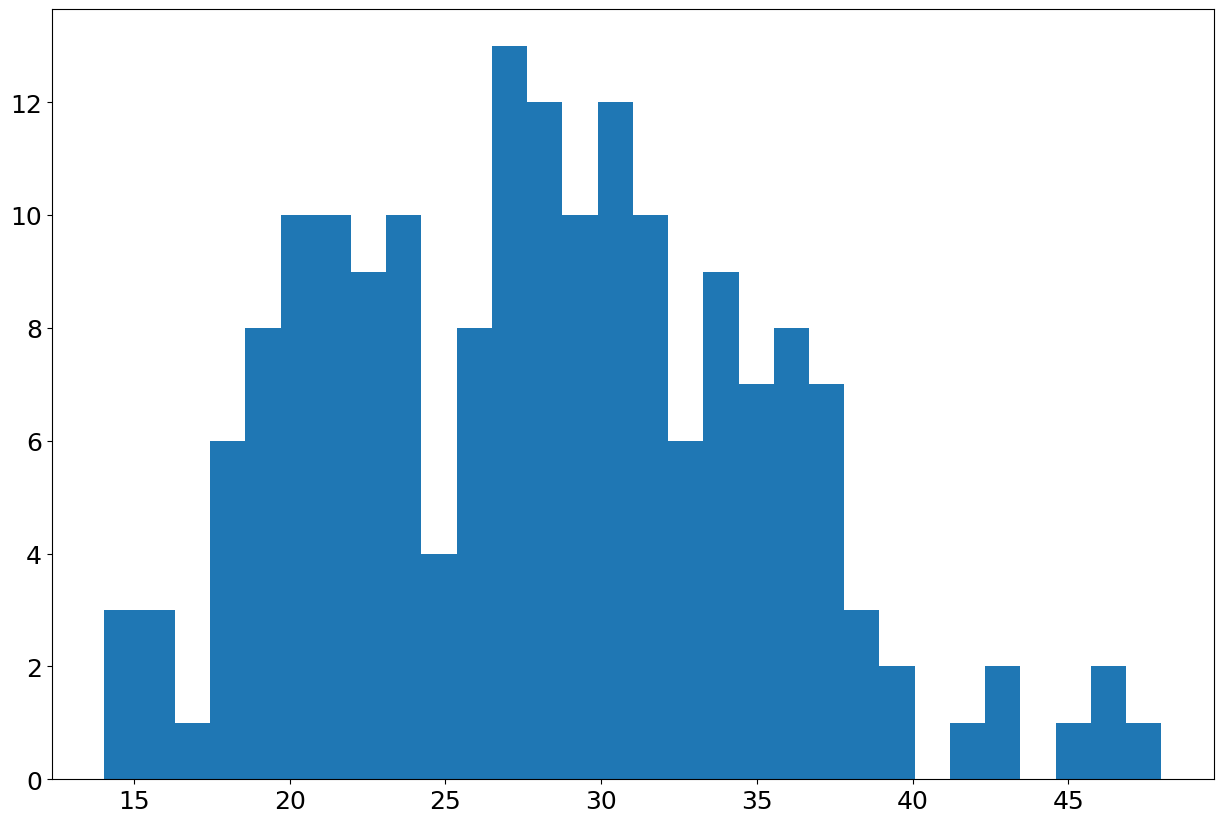

In [28]:
plt.hist(DSs.V_plus, bins=30)

(array([ 1.,  0.,  0.,  1.,  3.,  4.,  4.,  5., 11.,  9., 16., 12., 13.,
        13.,  7.,  7.,  7.,  7.,  3., 13.,  7.,  7.,  7.,  2.,  6.,  5.,
         3.,  3.,  0.,  2.]),
 array([21.92 , 24.503, 27.086, 29.669, 32.252, 34.835, 37.418, 40.001,
        42.584, 45.167, 47.75 , 50.333, 52.916, 55.499, 58.082, 60.665,
        63.248, 65.831, 68.414, 70.997, 73.58 , 76.163, 78.746, 81.329,
        83.912, 86.495, 89.078, 91.661, 94.244, 96.827, 99.41 ]),
 <BarContainer object of 30 artists>)

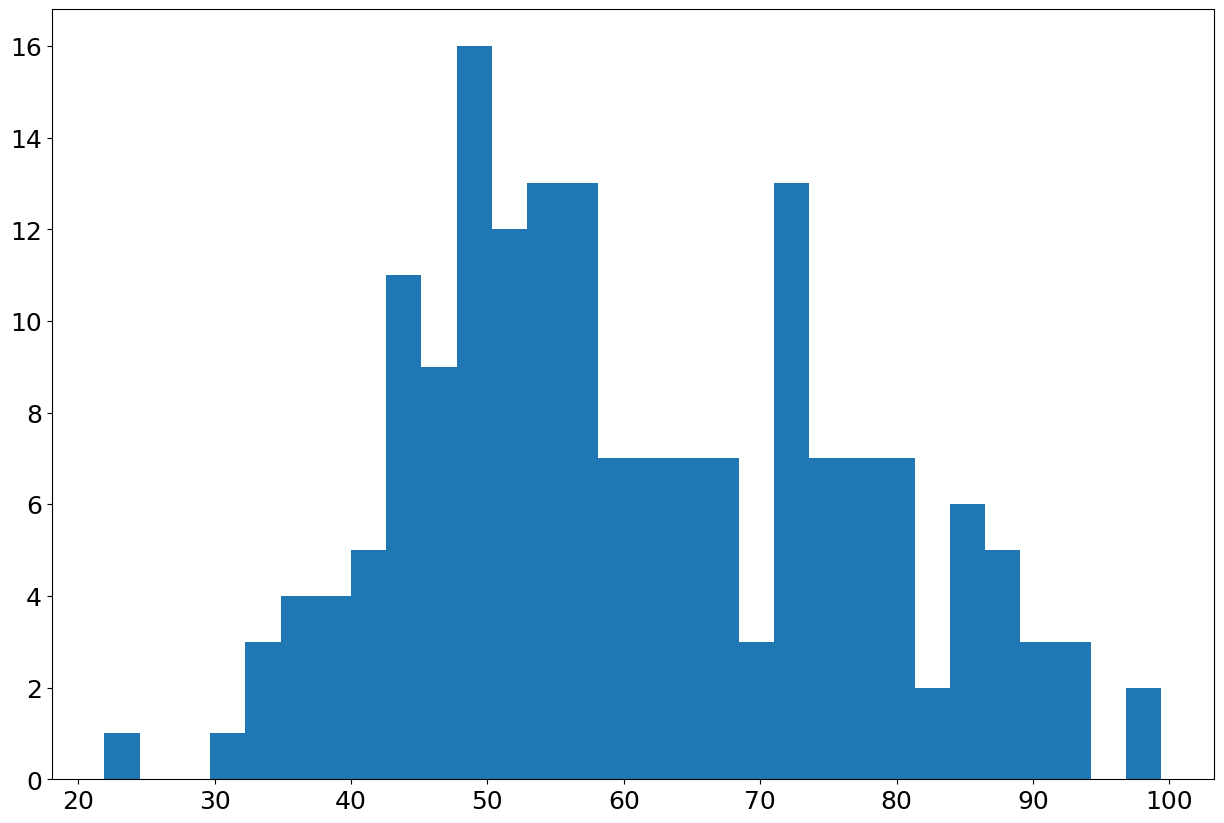

In [ ]:
plt.hist(DSs.R_plus / 1000, bins=30)

In [23]:
print(float(DSs.R0.mean()) / 1000)
print(float(DSs.R17_1D.mean()))

AttributeError: 'Dataset' object has no attribute 'R0'

#### Tests

In [ ]:
plt.scatter(DSs.Vmin_hol, DSs.B_hol, c=abs(DSs.cyclone_speed));plt.colorbar()

In [ ]:
plt.scatter(DSs.Vmin_hol, DSs.cyclone_speed)

In [ ]:
plt.scatter(DSs.Vmax_1D, DSs.Vmin_hol ** 2 +  (DSs.B_hol * 10) ** 2)

In [ ]:
plt.scatter(np.array(DSs.Vmin_hol), np.array(DSs.wind_speed.min(dim='rad', skipna=True)), c=DSs.B_hol)

In [ ]:
plt.scatter(DSs.Vmax_1D, (DSs.R_plus / 1000) / DSs.Rmax_1D)

In [ ]:
plt.scatter(DSs.Vmax_1D, DSs.V_plus)

In [ ]:
# Rmax*
D_hgh = DSs.where(DSs.Vmax_1D > thrsh, drop=True)
(D_hgh.Rmax_1D * 1000 / D_hgh.R_plus).mean(skipna=True)

bins = plt.hist(DSs.Rmax_1D * 1000 / DSs.R_plus, weights=np.zeros_like(DSs.Rmax_1D * 1000 / DSs.R_plus) + 1. / float((DSs.Rmax_1D * 1000 / DSs.R_plus).notnull().sum()),     bins=30, color='tab:gray', alpha=0.5,     label='All')
plt.hist(D_hgh.Rmax_1D * 1000 / D_hgh.R_plus,    weights=np.zeros_like(D_hgh.Rmax_1D * 1000 / D_hgh.R_plus) + 1. / float((D_hgh.Rmax_1D * 1000 / D_hgh.R_plus).notnull().sum()), bins=bins[1], color='tab:red', alpha=0.3, label='Storms > 40 m/s')
plt.legend()

In [ ]:
plt.scatter(DSs.R17_1D * 1000 * 17.5 ** 2, DSs.R_plus * DSs.V_plus ** 2, c=DSs.Vmax_1D, cmap=cm.get_cmap('coolwarm'), vmin=30, vmax=60)
plt.plot([0, 1.2e8], [0, 1.2e8], c='k')
plt.colorbar()

In [ ]:
plt.scatter(DSs.B_hol, DSs.Vmax_1D, c=rossby, cmap=cm.get_cmap('coolwarm'), vmin=5, vmax=100)
plt.colorbar()
plt.xlabel('B')
plt.ylabel('Vm')
plt.title('Rossby', weight='bold')

In [ ]:
plt.scatter(DSs.B_hol, DSs.Rmax_1D)

In [ ]:
plt.hist(rossby, bins=50)
plt.hist(D_hgh.Vmax_1D / (abs(coriolis(D_hgh.lat_center)) * D_hgh.Rmax_1D * 1000), bins=50)

In [ ]:
plt.scatter(rossby, DSs.B_hol, c=DSs.Vmin_hol, cmap=cm.get_cmap('coolwarm'), vmin=3, vmax=12)

In [ ]:
plt.hist(DSs.pn_hol - DSs.pc_hol)

In [ ]:
ro = DSs.Vmax_hol / (abs(coriolis(DSs.lat_center)) * DSs.Rmax_hol * 1000)
x  = DSs.Vmax_hol ** 2 * np.sqrt(2 * ro)
y  = DSs.Vmax_hol ** 2 / DSs.B_hol
plt.scatter(x, y, c=DSs.Vmin_hol, cmap=cm.get_cmap('coolwarm'), vmin=3, vmax=12)
plt.colorbar()

In [ ]:
ro = DSs.Vmax_hol / (abs(coriolis(DSs.lat_center)) * DSs.Rmax_hol * 1000)
x  = np.sqrt(2 * ro)
y  = DSs.B_hol
plt.scatter(x / x.mean(skipna=True), y / y.mean(skipna=True), c=DSs.Vmin_hol, cmap=cm.get_cmap('coolwarm'), vmin=3, vmax=12)
plt.colorbar()

In [ ]:
ro = DSs.Vmax_hol / (abs(coriolis(DSs.lat_center)) * DSs.Rmax_hol * 1000)
x  = (np.exp(1) * (1 - (DSs.Vmin_hol / DSs.Vmax_hol)) ** 2) / np.sqrt(2 * ro)
y  = DSs.B_hol
plt.scatter(x, y)

In [ ]:
plt.hist(DSs.Vmax_1D / (DSs.Rmax_1D * 1000), bins=30)

In [ ]:
plt.hist(DSs.Vmax_1D / (abs(coriolis(DSs.lat_center)) * DSs.Rmax_1D * 1000), bins=20)

In [ ]:
plt.hist(dss.Vfm)

In [ ]:
plt.scatter(DSs.Vmax_1D, DSs.x_rkn)

In [ ]:
plt.scatter(DSs.x_rkn, DSs.B_hol)

In [ ]:
fig, ax     = plt.subplots(figsize=(15, 10))

c_min = 2
c_max = 8

dss['Vfm_color'] = (dss.Vfm - c_min) / (c_max - c_min)
cmap           = cm.get_cmap('coolwarm')

rv2m = dss.mean(dim='i').rv2
rv2s = dss.std(dim='i').rv2

# Iterate
for i in tqdm(np.arange(len(dss.i))):
    dss.isel(i=i).rv2.plot(color=cmap(dss.isel(i=i).Vfm_color), alpha=0.8)

# Mean and std
rv2m.plot(c='k', linewidth=3, label='Average of {} SAR cases'.format(len(dss.i)))
ax.plot(dss.r_star, rv2m + rv2s, c='k', linestyle='dashed', linewidth=3, label='Standard deviation')
ax.plot(dss.r_star, rv2m - rv2s, c='k', linestyle='dashed', linewidth=3)

# Wind radii
# plt.axvline(1, c='k', linewidth=3, label='R+')
# ax.axvline((DSs.R17_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True), ymin=0, ymax=float(rv2m.sel(r_star=(DSs.R17_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True), method='nearest')) / 2.75, linewidth=1.5, c='k', alpha=0.8)
# ax.axvline((DSs.R33_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True), ymin=0, ymax=float(rv2m.sel(r_star=(DSs.R33_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True), method='nearest')) / 2.75, linewidth=1.5, c='k', alpha=0.8)
ax.axvline((DSs.Rmax_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True), ymin=0, ymax=float(rv2m.sel(r_star=(DSs.Rmax_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True), method='nearest')) / 2.7, linewidth=1.5, c='k', alpha=0.8)
trans = ax.get_xaxis_transform()
# ax.text((DSs.R17_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True) - 0.12,  .015, r'$R_{34}$$_{*}$',  c='k', alpha=0.8, transform=trans, rotation='vertical')
# ax.text((DSs.R33_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True) - 0.12,  .015, r'$R_{64}$$_{*}$',  c='k', alpha=0.8, transform=trans, rotation='vertical')
ax.text((DSs.Rmax_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True) - 0.12, .015, r'$R_{max}$$_{*}$', c='k', alpha=0.8, transform=trans, rotation='vertical')
# R0
R0 = np.sqrt(2 * DSs.Rmax_1D * 1000 * DSs.Vmax_1D / (abs(coriolis(DSs.lat_center)))).mean(skipna=True)
ax.axvline(R0 / DSs.R_plus.mean(skipna=True), ymin=0, ymax=0.34, linewidth=1.5, c='k', alpha=0.8)
ax.text(R0 / DSs.R_plus.mean(skipna=True) - 0.12, .015, r'$R_{0}$$_{*}$', c='k', alpha=0.8, transform=trans, rotation='vertical')


# Grid, legend
# ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
# ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylim(-0.15, 3);ax.set_xlim(0, 5)
ax.set_ylabel(r'$\pi$ $=$ $\frac{rv^2}{R_{+} V_{+}^2}$')
ax.set_xlabel(r'$r_{*}$ $=$ $\frac{r}{R_{+}}$')
ax.legend(loc='upper left', frameon=False)

# Colorbar
norm = mpl.colors.Normalize(vmin=c_min, vmax=c_max)
sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cb_ax = fig.add_axes([0.91, 0.11, 0.018, 0.77])
cbar  = fig.colorbar(sm, cax=cb_ax)
cbar.set_label('Storm speed (m/s)', rotation=90)
cbar.ax.get_yaxis().labelpad=8

if PRMS['save_figs']:
    plt.savefig(PTHS['save_dir'] + 'rv2_charac.pdf', bbox_inches='tight', format='pdf')

In [ ]:
plt.hist(dss.x)

In [ ]:
fig, ax     = plt.subplots(figsize=(15, 10))

c_min = 0.3
c_max = 1.1

dss['x_color'] = (dss.x - c_min) / (c_max - c_min)
cmap           = cm.get_cmap('coolwarm')

rv2m = dss.mean(dim='i').rv2
rv2s = dss.std(dim='i').rv2

# Iterate
for i in tqdm(np.arange(len(dss.i))):
    dss.isel(i=i).rv2.plot(color=cmap(dss.isel(i=i).x_color), alpha=0.8)

# Mean and std
rv2m.plot(c='k', linewidth=3, label='Average of {} SAR cases'.format(len(dss.i)))
ax.plot(dss.r_star, rv2m + rv2s, c='k', linestyle='dashed', linewidth=3, label='Standard deviation')
ax.plot(dss.r_star, rv2m - rv2s, c='k', linestyle='dashed', linewidth=3)

# Wind radii
# plt.axvline(1, c='k', linewidth=3, label='R+')
# ax.axvline((DSs.R17_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True), ymin=0, ymax=float(rv2m.sel(r_star=(DSs.R17_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True), method='nearest')) / 2.75, linewidth=1.5, c='k', alpha=0.8)
# ax.axvline((DSs.R33_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True), ymin=0, ymax=float(rv2m.sel(r_star=(DSs.R33_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True), method='nearest')) / 2.75, linewidth=1.5, c='k', alpha=0.8)
ax.axvline((DSs.Rmax_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True), ymin=0, ymax=float(rv2m.sel(r_star=(DSs.Rmax_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True), method='nearest')) / 2.7, linewidth=1.5, c='k', alpha=0.8)
trans = ax.get_xaxis_transform()
# ax.text((DSs.R17_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True) - 0.12,  .015, r'$R_{34}$$_{*}$',  c='k', alpha=0.8, transform=trans, rotation='vertical')
# ax.text((DSs.R33_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True) - 0.12,  .015, r'$R_{64}$$_{*}$',  c='k', alpha=0.8, transform=trans, rotation='vertical')
ax.text((DSs.Rmax_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True) - 0.12, .015, r'$R_{max}$$_{*}$', c='k', alpha=0.8, transform=trans, rotation='vertical')
# R0
R0 = np.sqrt(2 * DSs.Rmax_1D * 1000 * DSs.Vmax_1D / (abs(coriolis(DSs.lat_center)))).mean(skipna=True)
ax.axvline(R0 / DSs.R_plus.mean(skipna=True), ymin=0, ymax=0.34, linewidth=1.5, c='k', alpha=0.8)
ax.text(R0 / DSs.R_plus.mean(skipna=True) - 0.12, .015, r'$R_{0}$$_{*}$', c='k', alpha=0.8, transform=trans, rotation='vertical')


# Grid, legend
# ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
# ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylim(-0.15, 3);ax.set_xlim(0, 5)
ax.set_ylabel(r'$\pi$ $=$ $\frac{rv^2}{R_{+} V_{+}^2}$')
ax.set_xlabel(r'$r_{*}$ $=$ $\frac{r}{R_{+}}$')
ax.legend(loc='upper left', frameon=False)

# Colorbar
norm = mpl.colors.Normalize(vmin=c_min, vmax=c_max)
sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cb_ax = fig.add_axes([0.91, 0.11, 0.018, 0.77])
cbar  = fig.colorbar(sm, cax=cb_ax)
cbar.set_label('Rankine power', rotation=90)
cbar.ax.get_yaxis().labelpad=8

if PRMS['save_figs']:
    plt.savefig(PTHS['save_dir'] + 'rv2_charac.pdf', bbox_inches='tight', format='pdf')

In [ ]:
fig, ax     = plt.subplots(figsize=(15, 10))

c_min = 25
c_max = 55

dss['Vm_color'] = (dss.Vmax - c_min) / (c_max - c_min)
cmap            = cm.get_cmap('coolwarm')

rv2m = dss.mean(dim='i').rv2
rv2s = dss.std(dim='i').rv2

# Iterate
for i in tqdm(np.arange(len(dss.i))):
    dss.isel(i=i).rv2.plot(color=cmap(dss.isel(i=i).Vm_color), alpha=0.6)

# Mean and std
rv2m.plot(c='k', linewidth=3, label='Average of {} SAR cases'.format(len(dss.i)))
ax.plot(dss.r_star, rv2m + rv2s, c='k', linestyle='dashed', linewidth=3, label='Standard deviation')
ax.plot(dss.r_star, rv2m - rv2s, c='k', linestyle='dashed', linewidth=3)

# Wind radii
ax.axvline((DSs.Rmax_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True), ymin=0, ymax=float(rv2m.sel(r_star=(DSs.Rmax_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True), method='nearest')) / 2.7, linewidth=1.5, c='k', alpha=0.8)
trans = ax.get_xaxis_transform()
ax.text((DSs.Rmax_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True) - 0.12, .015, r'$R_{max}$$_{*}$', c='k', alpha=0.8, transform=trans, rotation='vertical')
# R0
R0 = np.sqrt(2 * DSs.Rmax_1D * 1000 * DSs.Vmax_1D / (abs(coriolis(DSs.lat_center)))).mean(skipna=True)
ax.axvline(R0 / DSs.R_plus.mean(skipna=True), ymin=0, ymax=0.34, linewidth=1.5, c='k', alpha=0.8)
ax.text(R0 / DSs.R_plus.mean(skipna=True) - 0.12, .015, r'$R_{0}$$_{*}$', c='k', alpha=0.8, transform=trans, rotation='vertical')


# Grid, legend
# ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
# ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylim(-0.15, 3);ax.set_xlim(0, 5)
ax.set_ylabel(r'$\pi$ $=$ $\frac{rv^2}{R_{+} V_{+}^2}$')
ax.set_xlabel(r'$r_{*}$ $=$ $\frac{r}{R_{+}}$')
ax.legend(loc='upper left', frameon=False)

# Colorbar
norm = mpl.colors.Normalize(vmin=c_min, vmax=c_max)
sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cb_ax = fig.add_axes([0.91, 0.11, 0.018, 0.77])
cbar  = fig.colorbar(sm, cax=cb_ax)
cbar.set_label('Vmax (m/s)', rotation=90)
cbar.ax.get_yaxis().labelpad=8

if PRMS['save_figs']:
    plt.savefig(PTHS['save_dir'] + 'rv2_charac.pdf', bbox_inches='tight', format='pdf')

In [ ]:
fig, ax     = plt.subplots(figsize=(15, 10))

c_min = 15
c_max = 25

dss['lat_color'] = (abs(dss.lat) - c_min) / (c_max - c_min)
cmap             = cm.get_cmap('coolwarm')

rv2m = dss.mean(dim='i').rv2
rv2s = dss.std(dim='i').rv2

# Iterate
for i in tqdm(np.arange(len(dss.i))):
    dss.isel(i=i).rv2.plot(color=cmap(dss.isel(i=i).lat_color), alpha=0.6)

# Mean and std
rv2m.plot(c='k', linewidth=3, label='Average of {} SAR cases'.format(len(dss.i)))
ax.plot(dss.r_star, rv2m + rv2s, c='k', linestyle='dashed', linewidth=3, label='Standard deviation')
ax.plot(dss.r_star, rv2m - rv2s, c='k', linestyle='dashed', linewidth=3)

# Wind radii
ax.axvline((DSs.Rmax_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True), ymin=0, ymax=float(rv2m.sel(r_star=(DSs.Rmax_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True), method='nearest')) / 2.7, linewidth=1.5, c='k', alpha=0.8)
trans = ax.get_xaxis_transform()
ax.text((DSs.Rmax_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True) - 0.12, .015, r'$R_{max}$$_{*}$', c='k', alpha=0.8, transform=trans, rotation='vertical')
# R0
R0 = np.sqrt(2 * DSs.Rmax_1D * 1000 * DSs.Vmax_1D / (abs(coriolis(DSs.lat_center)))).mean(skipna=True)
ax.axvline(R0 / DSs.R_plus.mean(skipna=True), ymin=0, ymax=0.34, linewidth=1.5, c='k', alpha=0.8)
ax.text(R0 / DSs.R_plus.mean(skipna=True) - 0.12, .015, r'$R_{0}$$_{*}$', c='k', alpha=0.8, transform=trans, rotation='vertical')


# Grid, legend
# ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
# ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylim(-0.15, 3);ax.set_xlim(0, 5)
ax.set_ylabel(r'$\pi$ $=$ $\frac{rv^2}{R_{+} V_{+}^2}$')
ax.set_xlabel(r'$r_{*}$ $=$ $\frac{r}{R_{+}}$')
ax.legend(loc='upper left', frameon=False)

# Colorbar
norm = mpl.colors.Normalize(vmin=c_min, vmax=c_max)
sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cb_ax = fig.add_axes([0.91, 0.11, 0.018, 0.77])
cbar  = fig.colorbar(sm, cax=cb_ax)
cbar.set_label('Latitude (abs °)', rotation=90)
cbar.ax.get_yaxis().labelpad=8

if PRMS['save_figs']:
    plt.savefig(PTHS['save_dir'] + 'rv2_charac.pdf', bbox_inches='tight', format='pdf')

In [ ]:
plt.scatter(abs(dss.lat), dss.Vmax)

In [ ]:
plt.scatter(DSs.Rmax_1D, DSs.R17_1D, c=DSs.R_plus / 1000, cmap=cm.get_cmap('jet'))
plt.colorbar()

In [ ]:
plt.scatter(DSs.Rmax_1D, DSs.R_plus / 1000, c=DSs.R17_1D, cmap=cm.get_cmap('jet'))
plt.colorbar()

In [ ]:
plt.scatter(DSs.R17_1D, DSs.R_plus / 1000, c=DSs.Rmax_1D, cmap=cm.get_cmap('jet'), vmin=10, vmax=70)
plt.colorbar()

In [ ]:
plt.scatter(DSs.Rmax_1D, DSs.R_plus / 1000, c=DSs.Vmax_dot_smth_IBT, vmin=-0.5, vmax=0.5, cmap=cm.get_cmap('coolwarm', 3))

In [ ]:
plt.scatter(DSs.R17_1D, DSs.R_plus / 1000)

In [ ]:
plt.scatter(DSs.R_plus, DSs.B_hol)

In [ ]:
plt.scatter(DSs.V_plus, DSs.Vmax_1D)

In [ ]:
plt.scatter(DSs.V_plus, DSs.Vmax_1D)

In [ ]:
plt.scatter(DSs.R_plus, DSs.R33_1D)

In [ ]:
plt.hist(DSs.R_plus, bins=50)

#### Test with R+ = Rmax

In [ ]:
# ITERATE
listOfDatasets = []
rf             = np.linspace(0.05, 5, 100)

for t in tqdm(np.arange(len(DSs.time))):
    ds  = DSs.isel(time=t)
    rv2 = (ds.rad * (ds.wind_speed ** 2)) / (ds.Rmax_1D * 1000 * (ds.Vmax_1D ** 2))
    
    if ~np.isnan(ds.Rmax_1D):
        dsr = xr.Dataset(
            data_vars={
                'rv2': ('r_star', np.array(rv2)),
                'B':   float(ds.B_hol),
            },
            coords={'r_star': np.array(ds.rad / (ds.Rmax_1D * 1000))}
        )
        listOfDatasets.append(dsr.interp(coords={'r_star': rf}))

print('Concatenating...')
dss2 = xr.concat(listOfDatasets, dim='i')
print('Concatenation ended.')

In [ ]:
dss2['B_color'] = (dss2.B - 1.1) / (2.5 - 1.1)
cmap           = cm.get_cmap('coolwarm')

rv2m = dss2.mean(dim='i').rv2
rv2s = dss2.std(dim='i').rv2

for i in tqdm(np.arange(len(dss2.i))):
    dss2.isel(i=i).rv2.plot(color=cmap(dss2.isel(i=i).B_color), alpha=0.8)

rv2m.plot(c='k', linewidth=3, label='SAR Mean')
plt.plot(dss2.r_star, rv2m + rv2s, c='k', linestyle='dashed', linewidth=3)
plt.plot(dss2.r_star, rv2m - rv2s, c='k', linestyle='dashed', linewidth=3)


# plt.axvline(1, c='k', linewidth=3, label='R+')
plt.axvline((DSs.R17_1D.mean(skipna=True)) / DSs.Rmax_1D.mean(skipna=True),  c='forestgreen', label='R34', linewidth=3)
plt.axvline((DSs.R33_1D.mean(skipna=True)) / DSs.Rmax_1D.mean(skipna=True),  c='lightseagreen', label='R64', linewidth=3)
plt.axvline((DSs.Rmax_1D.mean(skipna=True)) / DSs.Rmax_1D.mean(skipna=True), c='aquamarine', label='Rmax', linewidth=3)
plt.grid();plt.legend()
plt.ylim(0, 2)
plt.ylabel(r'$\frac{rv^2}{R_{+} V_{+}^2}$')
plt.xlabel(r'$\frac{r}{R_{+}}$')
# plt.xlabel('r / R+')

#### R0

In [ ]:
DSs['R0'] = np.sqrt(2 * DSs.Rmax_1D * 1000 * DSs.Vmax_1D / abs(coriolis(DSs.lat_center)))

In [ ]:
plt.hist(DSs['R0'], bins=50)

In [ ]:
plt.scatter(DSs.R17_1D, DSs.R0 / 1000, c=DSs.B_hol, cmap=cm.get_cmap('coolwarm', 5))
plt.plot([100, 400], [100, 400])
plt.show()
plt.scatter(DSs.Rmax_1D, DSs.R0);plt.show()

In [ ]:
plt.scatter(DSs.R_plus, DSs.Rmax_1D)

In [ ]:
plt.scatter(DSs.R_plus / 1000, DSs.Rmax_1D)

In [ ]:
plt.scatter(DSs.R_plus / 1000, DSs.R0 / 1000, c=DSs.Rmax_1D, vmin=20, vmax=60);plt.colorbar()

In [ ]:
plt.scatter(DSs.R_plus / 1000, DSs.R0 / 1000, c=DSs.Vmax_dot_smth_IBT, vmin=-1, vmax=1, cmap=cm.get_cmap('coolwarm', 3));plt.colorbar()

In [ ]:
plt.scatter(DSs.R_plus / 1000, DSs.R0 / 1000, c=DSs.cyclone_speed, vmin=2, vmax=8, cmap=cm.get_cmap('coolwarm', 3));plt.colorbar()

In [ ]:
plt.scatter(DSs.Rmax_1D, DSs.R0 / 1000)